In [8]:
import scipy.io
import numpy as np
import sys 
sys.path.append('../')
import math
import matplotlib.pyplot as plt
# import opal as Opal
from scipy.spatial.transform import Rotation as R
from sklearn.decomposition import PCA

In [9]:
# import test data from thigh and shank to calculate knee angles 
shank_data = np.loadtxt("DataShank.txt", delimiter=',')
thigh_data = np.loadtxt("DataThigh.txt", delimiter=',')


In [10]:
print(shank_data[:,3:6].shape)

(10001, 3)


In [11]:
def EKF(gyro, accl, dt):

    # Initialization
    n, m = gyro.shape
    X_all = np.zeros((n, 4))                                    # quaternion state
    P_all = np.zeros((4, 4, n))                                 # error covariance matrix
    bias_w = np.array([0, 0, 0])                                # gyroscope bias   
    bias_a = np.array([0, 0, 0])                                # accelerometer bias
    noise_w = 0.002 ** 2                                        # gyroscope error variance
    noise_a = 0.02 ** 2                                         # accelerometer error variance
    gc = 9.80665                                                # gravity magnitude, m/s^2

    initX = np.array([math.cos(np.pi/4), math.sin(np.pi/4), 0, 0])                              # can change to better initial prediction
    initP = np.eye(4) * 1e-4                                    # can change to better initial prediction
    X_all[0,:] = initX
    P_all[:,:,0] = initP
    x = initX
    P = initP

    for i in range(1, n):
        # ========= Predict -- gyroscope propagation ========= 
        w = gyro[i, :] - bias_w

        omega = np.array([[0, -w[0], -w[1], -w[2]], 
                          [w[0], 0, w[2], -w[1]],
                          [w[1], -w[2], 0, w[0]],
                          [w[2], w[1], -w[0], 0]])              
        FD = np.eye(4) + dt * omega / 2                    # propagation dynamics

        C = np.array([[-x[1], -x[2], -x[3]],
                      [x[0], -x[3], x[2]],
                      [x[3], x[0], -x[1]],
                      [-x[2], x[1], x[0]]]) / 2
        Q = (dt ** 2) * np.matmul(np.matmul(C, (noise_w * np.eye(3))), C.T)      # process noise matrix

        # Propagate the state and covariance
        x = np.matmul(FD, x)
        x = x / np.linalg.norm(x)                                      # normalize
        P = np.matmul(np.matmul(FD, P), FD.T) + Q 

        # ========= Measurement Update ========= 
        a = accl[i, :] - bias_a
        a = a.reshape(3,1)

        # Use non-linear equation to estimate prediction
        a_pred = gc * np.array([[2*(x[1]*x[3] - x[0]*x[2])], 
                                [2*(x[2]*x[3] + x[0]*x[1])], 
                                [x[0]**2 - x[1]**2 - x[2]**2 + x[3]**2]])
        
        H = 2 * gc * np.array([[-x[2], x[3], -x[0], x[1]],
                                [x[1], x[0], x[3], x[2]],
                                [x[0], -x[1], -x[2], x[3]]])     # measurement matrix

        # Measurement noise R is appropriate when the acceleration magnitude is approximately equal to gravity
        check = abs(np.linalg.norm(a) - gc)
        epsilon = 0.05                                          # tolerance

        if check < epsilon:
            R = np.eye(3) * noise_a
        else:
            R = np.eye(3) * 100

        # ========= Kalman Update ========= 
        K = np.matmul(np.matmul(P, H.T), np.linalg.inv(np.matmul(np.matmul(H, P), H.T) + R))
        x = x + np.matmul(K, (a - a_pred)).reshape(4,)
        x = x / np.linalg.norm(x)                                      # normalize
        P = np.matmul((np.eye(4) - np.matmul(K, H)), P)

        #  ========= Append to variables ========= 
        X_all[i, :] = x
        P_all[:, :, i] = P
    
    return X_all, P_all

In [117]:
def quat2euler(quat_mat, seq):
    quat_wlast = np.hstack([quat_mat[:, 1:], quat_mat[:, 0].reshape(-1, 1)])
    r = R.from_quat(quat_wlast)
    return r.as_euler(seq, degrees=True)

def rad2deg(rad):
    return rad * 180.0 / np.pi

In [13]:
X_shank, P_shank = EKF(shank_data[:,3:6], shank_data[:,0:3], 1e-3)
X_thigh, P_thigh = EKF(thigh_data[:,3:6], thigh_data[:,0:3], 1e-3)
eul_shank = quat2euler(X_shank, 'zyx')
eul_thigh = quat2euler(X_thigh, 'zyx')

[0, 10001L, -30, 30]

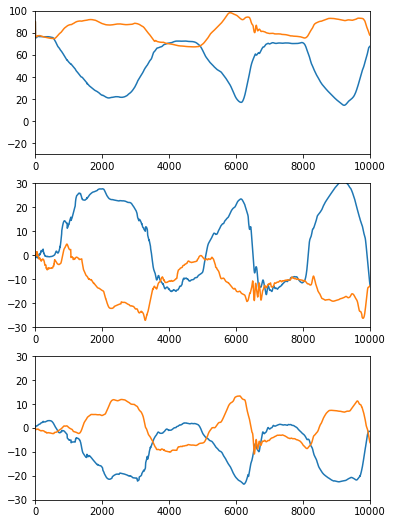

In [116]:
n, m = shank_data.shape

plt.figure(figsize=(6,9))
plt.subplot(311)
plt.plot(np.arange(0,n), eul_thigh[:,2])
plt.plot(np.arange(0,n), eul_shank[:,2])
plt.axis([0, n, -30, 100])

plt.subplot(312)
plt.plot(np.arange(0,n), eul_thigh[:,1])
plt.plot(np.arange(0,n), eul_shank[:,1])
plt.axis([0, n, -30, 30])

plt.subplot(313)
plt.plot(np.arange(0,n), eul_thigh[:,0])
plt.plot(np.arange(0,n), eul_shank[:,0])
plt.axis([0, n, -30, 30])

In [15]:
def quat2rot(quat):
    """ 
    Convert a quaternion (N, 4) to rotation matrix (N, 3, 3). Input quaternions are expressed in scalar-first notation as (w, x, y, z).
    Inputs may be 2d or 3d arrays.
    """
    quat_wlast = np.hstack([quat[:, 1:], quat[:, 0].reshape(-1,1)])                   # convert to scalar-last notation for scipy Rotation function
    r = R.from_quat(quat_wlast)
    return r.as_dcm()

In [150]:
def angular_vel_wrt_frameA(R_A, R_B, gyro_A, gyro_B):
    """ 
    Finds the relative angular velocity with respect to IMU frame A. Rotation matrices are (N, 3, 3) arrays and gyroscope measurements are (N, 3) arrays.
    Returns (N, 3) array for rotation about (x, y, z). 
    """
    N, a, b = R_A.shape
    gyro_A_ = gyro_A.reshape((N, 3, 1))
    gyro_B_ = gyro_B.reshape((N, 3, 1))

    R_BA = np.matmul(R_A, np.transpose(R_B, (0, 2, 1)))                           # transpose last two dimensions, results in (N, 3, 3)
    w_rel_frameA = np.matmul(R_BA, gyro_B_) - gyro_A_
    return w_rel_frameA.reshape((-1, 3))

def angular_vel_wrt_frameB(R_A, R_B, gyro_A, gyro_B):
    """ 
    Finds the relative angular velocity with respect to IMU frame B. Rotation matrices are (N, 3, 3) arrays and gyroscope measurements are (N, 3) arrays.
    Returns (N, 3) array for rotation about (x, y, z). 
    """
    N, a, b = R_A.shape
    gyro_A_ = gyro_A.reshape((N, 3, 1))
    gyro_B_ = gyro_B.reshape((N, 3, 1))

    R_AB = np.matmul(R_B, np.transpose(R_A, (0, 2, 1))) 
    w_rel_frameB = gyro_B_ - np.matmul(R_AB, gyro_A_)
    return w_rel_frameB.reshape((-1, 3))

In [162]:
R_WS = quat2rot(X_shank)
R_WT = quat2rot(X_thigh)
w_rel_thighframe = angular_vel_wrt_frameA(R_WT, R_WS, thigh_data[:,3:6], shank_data[:,3:6])
w_rel_shankframe = angular_vel_wrt_frameB(R_WT, R_WS, thigh_data[:,3:6], shank_data[:,3:6])
print(R_WS[1,:,:])
print(R_WT[1,:,:])

[[ 1.00000000e+00  2.21724716e-05 -1.27821422e-05]
 [-1.27853980e-05  1.46842633e-04 -9.99999989e-01]
 [-2.21705944e-05  9.99999989e-01  1.46842917e-04]]
[[ 9.99999998e-01 -5.51173113e-05  4.04786512e-05]
 [ 4.04856943e-05  1.27788804e-04 -9.99999991e-01]
 [ 5.51121381e-05  9.99999990e-01  1.27791035e-04]]


In [153]:
r = R.from_quat([0, 0, np.sin(-np.pi/4), np.cos(np.pi/4)])
print(r.as_dcm())

[[ 2.22044605e-16  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  2.22044605e-16 -0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00  1.00000000e+00]]


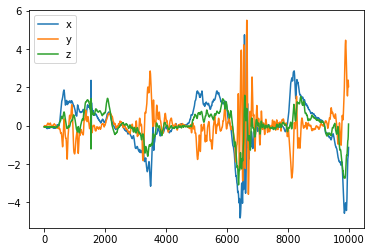

In [155]:
fig, ax = plt.subplots(1)

plt.plot(np.arange(0,n), w_rel_thighframe[:,0], label='x')
plt.plot(np.arange(0,n), w_rel_thighframe[:,1], label='y')
plt.plot(np.arange(0,n), w_rel_thighframe[:,2], label='z')
ax.legend()

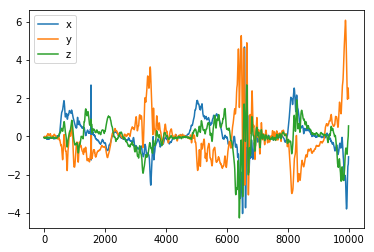

In [157]:
fig, ax = plt.subplots(1)

plt.plot(np.arange(0,n), w_rel_shankframe[:,0], label='x')
plt.plot(np.arange(0,n), w_rel_shankframe[:,1], label='y')
plt.plot(np.arange(0,n), w_rel_shankframe[:,2], label='z')
ax.legend()

In [158]:
def pc_axis(w_rel_frame_array):
    """ 
    Used to find anatomical frame axis using (N, 3) array of relative angular velocities with respect to a specific IMU frame (i.e. thigh IMU frame). 
    Returns the first principal component of the data (encaptures highest variability) as the principal axis. 
    """
    pca = PCA(n_components=3)
    pca.fit(w_rel_frame_array)
    axis = pca.components_[0]

    # Note: the estimated axis can converge to align with z or -z axis. Check if the axis is aligned with thigh z frame.
    # If the angle between the thigh x and estimated axis is less than 100, then it converged to align with +x instead of -x axis.
    cos_th = np.dot(axis, [1, 0, 0]) / (np.linalg.norm(axis) * np.linalg.norm([1, 0, 0]))
    ang = np.arccos(cos_th) * 180 / np.pi
    if ang < 100:
        # axis converged to negative of the desired axis
        axis = -1 * axis

    return axis

def calc_rot_from_axis(axis):
    """
    Use estimated (1, 3) axis to find appropriate (3, 3) rotation matrices. Assumes axis aligns with z-axis. 
    """
    z_T = axis
    y_init = [0, 1, 0]
    x_T = np.cross(y_init, z_T)
    x_T = x_T / np.linalg.norm(x_T)
    y_T = np.cross(z_T, x_T)

    return np.hstack((x_T.reshape(3,1), y_T.reshape(3,1), z_T.reshape(3,1)))

In [160]:
axis_thigh = pc_axis(w_rel_thighframe)
axis_shank = pc_axis(w_rel_shankframe)
R_AT_T = calc_rot_from_axis(axis_thigh)
R_AS_S = calc_rot_from_axis(axis_shank)
print(axis_shank)

[-0.49250585  0.81135227 -0.31487377]


In [108]:
def rot_AA_2_AB(R_AA, R_AB, R_A, R_B):
    """
    Rotation from anatomical frame AA to anatomical frame AB. 

    Inputs
    -------
    R_AA: (3, 3) rotation from IMU frame A to anatomical frame AA 
    R_AB: (3, 3) rotation from IMU frame B to anatomical frame AB
    R_A: (N, 3, 3) rotation from world frame to IMU frame A
    R_B: (N, 3, 3) rotation from world frame to IMU frame B

    Outputs
    -------
    R_AA_AB: rotation from anatomical frame AA to anatomical frame AB

    """
    rot1 = np.matmul(R_AA.T, R_A)
    rot2 = np.matmul(rot1, np.transpose(R_B, (0, 2, 1)))
    R_AA_AB = np.matmul(rot2, R_AB)
    return R_AA_AB

In [109]:
R_AS_AT = rot_AA_2_AB(R_AT_T, R_AS_S, R_WT, R_WS)

In [110]:
def ang_from_rot(R_AA_AB):
    """
    Calculates Euler angles from rotation matrix. Expressed as (rot_Z, rot_X, rot_Y) or (yaw, pitch, roll).
    Inputs may be 2d or 3d arrays. 
    """
    r = R.from_dcm(R_AA_AB)
    return r.as_euler('zxy', degrees=True)

<Figure size 432x216 with 0 Axes>

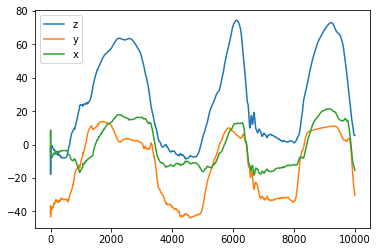

In [115]:
joint_angle = ang_from_rot(R_AS_AT)

plt.figure(figsize=(6,3))
fig, ax = plt.subplots(1)
plt.plot(np.arange(0,n), joint_angle[:,0], label='z')
plt.plot(np.arange(0,n), joint_angle[:,1], label='y')
plt.plot(np.arange(0,n), joint_angle[:,2], label='x')
ax.legend()